### Importing necessary libraries

In [1]:
!pip install wordcloud

  Using cached wordcloud-1.8.2.2.tar.gz (220 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for wordcloud
Failed to build wordcloud
  Running setup.py install for wordcloud: started
  Running setup.py install for wordcloud: finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [20 lines of output]
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-cpython-311
  creating build\lib.win-amd64-cpython-311\wordcloud
  copying wordcloud\color_from_image.py -> build\lib.win-amd64-cpython-311\wordcloud
  copying wordcloud\tokenization.py -> build\lib.win-amd64-cpython-311\wordcloud
  copying wordcloud\wordcloud.py -> build\lib.win-amd64-cpython-311\wordcloud
  copying wordcloud\wordcloud_cli.py -> build\lib.win-amd64-cpython-311\wordcloud
  copying wordcloud\_version.py -> build\lib.win-amd64-cpython-311\wordcloud
  copying wordcloud\__init__.py -> build\lib.win-amd64-cpython-311\wordcloud
  copying wordcloud\__main__.py -> build\lib.win-amd64-cpython-311\wordcloud
  copying wordcloud\stopwords -> build\lib.win-amd64-cpython-311\wordcloud
  copying wordcloud\DroidSansMono.ttf -> build\lib.win-amd64

In [2]:
!pip install opendatasets

In [3]:
!pip install --upgrade google-api-python-client

     --------------------------------------- 11.2/11.2 MB 50.4 MB/s eta 0:00:00
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 2.83.0
    Uninstalling google-api-python-client-2.83.0:
      Successfully uninstalled google-api-python-client-2.83.0


In [4]:
!pip install --upgrade google-auth-oauthlib google-auth-httplib2

In [5]:
!pip install isodate

In [6]:
import opendatasets as od
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
import numpy as np
import statistics as st
import plotly.express as px
import google_auth_oauthlib.flow
import googleapiclient.discovery
import googleapiclient.errors
from IPython.display import JSON
import isodate
from sklearn import metrics


warnings.filterwarnings('ignore')

### Loading the dataset from the source

In [7]:
dataset = 'https://www.kaggle.com/datasets/rsrishav/youtube-trending-video-dataset?select=US_youtube_trending_data.csv'

final_dir = '\\'.join(os.getcwd().split('\\')[:-1])

In [8]:
od.download(dataset, data_dir=final_dir)

final_dir += '\\youtube-trending-video-dataset\\US_youtube_trending_data.csv'

Skipping, found downloaded files in "C:\Users\timbe\Final Project\youtube-trending-video-dataset" (use force=True to force download)


In [9]:
data = pd.read_csv(final_dir)

data.head(3)

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11T19:20:14Z,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12T00:00:00Z,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,2020-08-11T17:00:10Z,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12T00:00:00Z,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,https://i.ytimg.com/vi/M9Pmf9AB4Mo/default.jpg,False,False,"While running her own modding shop, Ramya Pare..."
2,J78aPJ3VyNs,I left youtube for a month and THIS is what ha...,2020-08-11T16:34:06Z,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,24,2020-08-12T00:00:00Z,jacksepticeye|funny|funny meme|memes|jacksepti...,2038853,353787,2628,40221,https://i.ytimg.com/vi/J78aPJ3VyNs/default.jpg,False,False,I left youtube for a month and this is what ha...


### Understanding the data

In [10]:
# Checking null values

def null_values(df):
    temp = df.isna().sum()
    temp_1 = round(temp * 100 / df.shape[0], 2)
    
    return pd.DataFrame((temp, temp_1), index = ['Count', 'Percentage']).T.sort_values('Count', ascending = False)


null_df = null_values(data).reset_index().rename({'index':'Column_name'}, axis =1)
null_df

,Column_name,Count,Percentage
0,description,4048.0,2.18
1,video_id,0.0,0.00
2,title,0.0,0.00
3,publishedAt,0.0,0.00
4,channelId,0.0,0.00
5,channelTitle,0.0,0.00
6,categoryId,0.0,0.00
7,trending_date,0.0,0.00
8,tags,0.0,0.00
9,view_count,0.0,0.00


We can see that there are around 10% missing values in `description` column
- We are keeping the `description` column as it is while analysis and perform the null value treatment during model building.

In [11]:
# Checking the shape of the DataFrame
data.shape

(185990, 16)

In [12]:
# Let's check the unique video_ids in the `video_id` column
data['video_id'].nunique()

34066

- There are only 34066 unique videos out of 185990 video ids.
- That means there might be some duplicate data. Let's check if there is any.

In [13]:
# This code shows an example of how a randomly chosen video_id has continuous trending_dates

example_id = data['video_id'].value_counts().sort_values(ascending = False).index[np.random.randint(10,20)]

data[data['video_id'] == example_id]

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
127791,DfdbNFn8rqo,FIGHT HIGHLIGHTS | Canelo Álvarez vs. Dmitry B...,2022-05-08T06:41:19Z,UCurvRE5fGcdUgCYWgh-BDsg,DAZN Boxing,17,2022-05-09T00:00:00Z,dazn|boxing|highlights|full fight|ko|knockout|...,6880704,106458,0,19059,https://i.ytimg.com/vi/DfdbNFn8rqo/default.jpg,False,False,"May 7th, 2022 -- Canelo Álvarez vs. Dmitry Biv..."
127993,DfdbNFn8rqo,FIGHT HIGHLIGHTS | Canelo Álvarez vs. Dmitry B...,2022-05-08T06:41:19Z,UCurvRE5fGcdUgCYWgh-BDsg,DAZN Boxing,17,2022-05-10T00:00:00Z,dazn|boxing|highlights|full fight|ko|knockout|...,8118095,119878,0,20979,https://i.ytimg.com/vi/DfdbNFn8rqo/default.jpg,False,False,"May 7th, 2022 -- Canelo Álvarez vs. Dmitry Biv..."
128202,DfdbNFn8rqo,FIGHT HIGHLIGHTS | Canelo Álvarez vs. Dmitry B...,2022-05-08T06:41:19Z,UCurvRE5fGcdUgCYWgh-BDsg,DAZN Boxing,17,2022-05-11T00:00:00Z,dazn|boxing|highlights|full fight|ko|knockout|...,9042449,128118,0,22001,https://i.ytimg.com/vi/DfdbNFn8rqo/default.jpg,False,False,"May 7th, 2022 -- Canelo Álvarez vs. Dmitry Biv..."
128421,DfdbNFn8rqo,FIGHT HIGHLIGHTS | Canelo Álvarez vs. Dmitry B...,2022-05-08T06:41:19Z,UCurvRE5fGcdUgCYWgh-BDsg,DAZN Boxing,17,2022-05-12T00:00:00Z,dazn|boxing|highlights|full fight|ko|knockout|...,9594480,133356,0,22704,https://i.ytimg.com/vi/DfdbNFn8rqo/default.jpg,False,False,"May 7th, 2022 -- Canelo Álvarez vs. Dmitry Biv..."
128650,DfdbNFn8rqo,FIGHT HIGHLIGHTS | Canelo Álvarez vs. Dmitry B...,2022-05-08T06:41:19Z,UCurvRE5fGcdUgCYWgh-BDsg,DAZN Boxing,17,2022-05-13T00:00:00Z,dazn|boxing|highlights|full fight|ko|knockout|...,9951568,136598,0,23204,https://i.ytimg.com/vi/DfdbNFn8rqo/default.jpg,False,False,"May 7th, 2022 -- Canelo Álvarez vs. Dmitry Biv..."
128847,DfdbNFn8rqo,FIGHT HIGHLIGHTS | Canelo Álvarez vs. Dmitry B...,2022-05-08T06:41:19Z,UCurvRE5fGcdUgCYWgh-BDsg,DAZN Boxing,17,2022-05-14T00:00:00Z,dazn|boxing|highlights|full fight|ko|knockout|...,10179824,138835,0,23513,https://i.ytimg.com/vi/DfdbNFn8rqo/default.jpg,False,False,"May 7th, 2022 -- Canelo Álvarez vs. Dmitry Biv..."
129081,DfdbNFn8rqo,FIGHT HIGHLIGHTS | Canelo Álvarez vs. Dmitry B...,2022-05-08T06:41:19Z,UCurvRE5fGcdUgCYWgh-BDsg,DAZN Boxing,17,2022-05-15T00:00:00Z,dazn|boxing|highlights|full fight|ko|knockout|...,10361698,140456,0,23741,https://i.ytimg.com/vi/DfdbNFn8rqo/default.jpg,False,False,"May 7th, 2022 -- Canelo Álvarez vs. Dmitry Biv..."
129299,DfdbNFn8rqo,FIGHT HIGHLIGHTS | Canelo Álvarez vs. Dmitry B...,2022-05-08T06:41:19Z,UCurvRE5fGcdUgCYWgh-BDsg,DAZN Boxing,17,2022-05-16T00:00:00Z,dazn|boxing|highlights|full fight|ko|knockout|...,10494813,141653,0,23891,https://i.ytimg.com/vi/DfdbNFn8rqo/default.jpg,False,False,"May 7th, 2022 -- Canelo Álvarez vs. Dmitry Biv..."
129510,DfdbNFn8rqo,FIGHT HIGHLIGHTS | Canelo Álvarez vs. Dmitry B...,2022-05-08T06:41:19Z,UCurvRE5fGcdUgCYWgh-BDsg,DAZN Boxing,17,2022-05-17T00:00:00Z,dazn|boxing|highlights|full fight|ko|knockout|...,10585335,142511,0,24040,https://i.ytimg.com/vi/DfdbNFn8rqo/default.jpg,False,False,"May 7th, 2022 -- Canelo Álvarez vs. Dmitry Biv..."
129721,DfdbNFn8rqo,FIGHT HIGHLIGHTS | Canelo Álvarez vs. Dmitry B...,2022-05-08T06:41:19Z,UCurvRE5fGcdUgCYWgh-BDsg,DAZN Boxing,17,2022-05-18T00:00:00Z,dazn|boxing|highlights|full fight|ko|knockout|...,10667898,143242,0,24190,https://i.ytimg.com/vi/DfdbNFn8rqo/default.jpg,False,False,"May 7th, 2022 -- Canelo Álvarez vs. Dmitry Biv..."


We can see that there has been no change in data in any fields except the trending date column, since the video has been continuously present in the trending list since the published date only the trending date is getting updated everyday.

- We also observed that the data has certain important columns missing in it. Such as `VideoDuration` and `Comments` of video which are very useful for further analysis.
- We used `video_id` to extract the data from `YOUTUBE API`.
- The link for the Youtube API is: https://developers.google.com/youtube/v3/quickstart/python

### Extracting `Duration` and `Comments` from Youtube API

In [14]:
# First let's get unique video ids from the video_id column in dataframe

videos_list = data['video_id'].unique()

In [15]:
# The API_KEY is not displayed for security purposes

api_key = "*********************************"

In [16]:
# This fuction is used to extract 'Duration' and 'Comments' of a provided video_id

def get_video_info(vid_id, api_key):
    api_service_name = "youtube"
    api_version = "v3"

    youtube = googleapiclient.discovery.build(
        api_service_name, api_version, developerKey=api_key)

    request = youtube.videos().list(
        part="snippet,contentDetails,statistics,status",
        id=vid_id
    )
    
    response = request.execute()
    
    info_temp = []
    info_temp.append(vid_id)
    info_temp.append(response['items'][0]['contentDetails']['duration'])
    info_temp.append(response['items'][0]['status']['madeForKids'])
    
    youtube = googleapiclient.discovery.build(
    api_service_name, api_version, developerKey = api_key)

    request = youtube.commentThreads().list(
        part="snippet,replies",
        videoId=vid_id,
        textFormat = "plainText",
        order = "relevance"
    )
    response_comments = request.execute()
    
    info_temp.append([response_comments['items'][i]['snippet']['topLevelComment']['snippet']['textOriginal'] for i in range(20)])
    
    
    return info_temp



# This function is used to create a dataframe from the list of video_ids in video_list and save it in the repository.
# Start and end number is the range of video_ids you want the data for.

def data_to_csv(videos_list, start_number, end_number):
    print("Code Running")
    video_info = []
    deleted_videos = []
    
    for vid_id in videos_list[start_number : end_number]:
        try:
            video_info.append(get_video_info(vid_id, api_key))
        except:
            deleted_videos.append(vid_id)
    
    print("Number of videos extracted =", len(video_info))
    print("Number of video deleted =", len(deleted_videos))
    
    df = pd.DataFrame(video_info, columns = ['video_id', 'Duration', 'madeForKids', 'Comments'])
    df.to_csv('./YoutubeDataFiles/Data_' + str(start_number) + '_' + str(end_number) + '.csv')
    
    
# Saving the data to a .csv file by calling the funciton

#data_to_csv(videos_list, 0, 5000)

- Although it was possible to extract all the video_ids at once. It would cost money if you were to extract more than 5000.
- Hence, we used different API_KEYS and various start & end_numbers to save the files in the repository.
- The files are stored in `./YoutubeDataFiles` directory.
- The .csv files follow the convention `Data_startnumber_endnumber.csv`.

In [17]:
# Let's read the 'extracted files' in and merge them to merge with original Dataframe

extracted_df = pd.concat([pd.read_csv('./YoutubeDataFiles/' + file_csv, index_col = 0) for file_csv in os.listdir('./YoutubeDataFiles')],
                          ignore_index = True)

extracted_df.columns = ['video_id', 'videoDuration', 'madeForKids', 'Comments']

extracted_df.head()

,video_id,videoDuration,madeForKids,Comments
0,3C66w5Z0ixs,PT18M38S,False,"['*Whether she moved on, whether she’s been se..."
1,M9Pmf9AB4Mo,PT2M18S,False,"['She was fighting two squads and got flanked,..."
2,J78aPJ3VyNs,PT22M10S,False,"[""Let's see what memes you cooked up while I w..."
3,kXLn3HkpjaA,PT1M1S,False,"['Which 2020 XXL Freshman is your favorite?', ..."
4,VIUo6yapDbc,PT37M20S,False,['WE’RE SO OBSESSED!!!! Thank you guys times a...


In [18]:
# Checking the shape of the extracted dataset

extracted_df.shape

(31310, 4)

### Modifying the Original Dataframe

In [19]:
# Checking column name and values in the dataframe

data.head(1)

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11T19:20:14Z,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12T00:00:00Z,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...


In [20]:
# Checking the datatypes of each column

data.dtypes

video_id             object
title                object
publishedAt          object
channelId            object
channelTitle         object
categoryId            int64
trending_date        object
tags                 object
view_count            int64
likes                 int64
dislikes              int64
comment_count         int64
thumbnail_link       object
comments_disabled      bool
ratings_disabled       bool
description          object
dtype: object

Let's make the following changes to the Original Dataframe in 4 major steps:

1. Drop `channelId` column as it is not necessary for the analysis and prediction.
<br>

1. Convert `publishedAt` and `trending_date` to Pandas_Datetime object. Map each category_id to respective category in `categroty_id` column. This is done using `US_category_id.json` file from the source file.
<br>

2. Groupby `video_id` column and apply the following functions to the rest of the columns:
- `title` - <b>Function : MODE</b> - because title is same for each video_id.
- `publishedAT` - <b>Function : MODE</b> - although published date is same for each video_id. Let's consider minimum value.
- `channelTitle` - <b>Function : MODE</b> - because channel title is same for each video_id.
- `categroryId` - <b>Function : MODE</b> - because categoryId is same for each video_id.
- `trending_date` - <b>Function : [min(trending_date), max(trending_date)]</b> - this is because we can extract features like `How many days video took to trend` and `How many days the video have been trending`.
- `tags` - <b>Function : MODE</b> - because tags are same for each video_id.
- `likes` - <b>Function : [min(likes), max(likes)]</b> - this is because we can extract features like `How many likes have be increased during the period`.
- `comment_count` - <b>Function : [min(trending_date), max(trending_date)]</b> - this is because we can extract features like `Comments before and after trending`.
<br>
<br>
       
4. Drop `dislikes` column as the dislikes has been discontinued from November 2021.
Reference: https://www.google.com/search?q=when+did+youtube+remove+dislikes&rlz=1C1UEAD_enUS1037US1037&oq=when+did+youtube+remove+&aqs=chrome.0.0i512j69i57j0i512l6j0i22i30l2.6954j1j4&sourceid=chrome&ie=UTF-8



#### Step - 1

In [21]:
# Dropping channelId

data.drop(['channelId'], axis = 1, inplace = True)

# Validating the above code

data.head(3)

,video_id,title,publishedAt,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11T19:20:14Z,Brawadis,22,2020-08-12T00:00:00Z,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,2020-08-11T17:00:10Z,Apex Legends,20,2020-08-12T00:00:00Z,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,https://i.ytimg.com/vi/M9Pmf9AB4Mo/default.jpg,False,False,"While running her own modding shop, Ramya Pare..."
2,J78aPJ3VyNs,I left youtube for a month and THIS is what ha...,2020-08-11T16:34:06Z,jacksepticeye,24,2020-08-12T00:00:00Z,jacksepticeye|funny|funny meme|memes|jacksepti...,2038853,353787,2628,40221,https://i.ytimg.com/vi/J78aPJ3VyNs/default.jpg,False,False,I left youtube for a month and this is what ha...


#### Step - 2

- `publishedAt`, `trending_date` are object type. Let's convert it to Datetime format.

In [22]:
# Converting 'publishedAt' and 'trending_date' to datetime objects

data[['publishedAt', 'trending_date']] = data[['publishedAt', 'trending_date']].apply(lambda x: pd.to_datetime(x))

# Validating the above changes

data.dtypes[['publishedAt', 'trending_date']]

publishedAt      datetime64[ns, UTC]
trending_date    datetime64[ns, UTC]
dtype: object

We can see that `categoryId` column has id's of repective categories. We can access the description of categoryId from the `US_category_id.json` file.

In [23]:
# Let's import US_category_id.json file and map the category id's respectively

category_path = '\\'.join(final_dir.split('\\')[:-1]) + '\\US_category_id.json'


# Creating a dictionary object which stores the category id and its respective category
category_dict = {}

with open(category_path, 'r') as file:
    json_data = json.load(file)
    for item in json_data['items']:
        category_dict[int(item['id'])] = item['snippet']['title']
    
data['categoryId'] = data['categoryId'].apply(lambda x: category_dict[x])

# Validating the above code
data['categoryId'].head()

0    People & Blogs
1            Gaming
2     Entertainment
3             Music
4     Howto & Style
Name: categoryId, dtype: object

#### Step - 3 and 4

In [24]:
# This function converts list to min_max_list as per conditions specified in the above cell

def column_start_end(x: list) -> list:
    return [min(x), max(x)]

def description_col(x: list) -> str:
    temp = pd.Series(list(x))
    temp = temp[[not i for i in temp.isna()]]
    return temp.values[0] if len(temp) else ''

# Grouping by 'video_id' and aggregating using functions as specified in the above cell

modified_df = data.groupby('video_id').agg({'title':st.mode, 'publishedAt':np.min, 'channelTitle':st.mode, 'categoryId':st.mode,
              'trending_date': column_start_end, 'tags': st.mode, 'likes': column_start_end, 'view_count': column_start_end,
                'comment_count': column_start_end, 'comments_disabled': st.mode, 'ratings_disabled': st.mode,
                                           'description':description_col}).reset_index()

modified_df.head(2)

,video_id,title,publishedAt,channelTitle,categoryId,trending_date,tags,likes,view_count,comment_count,comments_disabled,ratings_disabled,description
0,--14w5SOEUs,Migos - Avalanche (Official Video),2021-06-10 16:00:00+00:00,MigosVEVO,Music,"[2021-06-11 00:00:00+00:00, 2021-06-15 00:00:0...",Migos|Avalanche|Quality|Control|Music/Motown|R...,"[122830, 262692]","[1076217, 6823249]","[9539, 16445]",False,False,Music video by Migos performing Avalanche. Qua...
1,--2O86Z0hsM,MY TESLA PAYS FOR ITSELF,2022-03-09 23:19:08+00:00,jf.okay,Entertainment,"[2022-03-11 00:00:00+00:00, 2022-03-15 00:00:0...",[None],"[16481, 17290]","[466980, 538485]","[1278, 1439]",False,False,


In [25]:
modified_df.shape

(34066, 13)

The resulting dataframe has 34066 rows and 10 columns.

Let's make the following changes to the resulting dataframe in 8 steps:
1. Create new columns `trending_date_start` & `trending_date_end` from `trending_date` column.
2. Create new columns `likes_start` & `likes_end` from `likes` column.
3. Create new columns `view_count_start` & `view_count_end` from `view_count` column.
3. `tags` have `[None]` values in it. Converting them to Null values.
4. Create new column `tagsCount` from `tags` column. Which indicates the number of tags used in particular video.
5. Create new column `hoursTakenToTrend` from `trending_date_start` & `publishedAt` columns.
6. Create new column `trendingDaysDuration` from `trending_date_end` & `trending_date_start` columns.
7. Drop columns `trending_date`, `likes`, `publishedAt`, `view_count` as they are no longer required.

#### Step - 1

In [26]:
# Create new columns trending_date_start & trending_date_end from trending_date column.

modified_df['trending_date_start'] = modified_df['trending_date'].apply(lambda x: min(x))
modified_df['trending_date_end'] = modified_df['trending_date'].apply(lambda x: max(x))

#### Step - 2

In [27]:
# Create new columns likes_start & likes_end from likes column.

modified_df['likes_start'] = modified_df['likes'].apply(lambda x: min(x))
modified_df['likes_end'] = modified_df['likes'].apply(lambda x: max(x))

#### Step - 3

In [28]:
# Create new columns `view_count_start` & `view_count_end` from `view_count` column.

modified_df['view_count_start'] = modified_df['view_count'].apply(lambda x: min(x))
modified_df['view_count_end'] = modified_df['view_count'].apply(lambda x: max(x))

#### Step - 4

In [29]:
# tags have [None] values in it. Converting them to Null values.

modified_df['tags'] = modified_df['tags'].apply(lambda x: x if x!= '[None]' else np.nan)

#### Step - 5

In [30]:
# Create new column tagsCount from tags column. Which indicates the number of tags used in particular video.

modified_df['tagCount'] = modified_df['tags'].apply(lambda x: 0 if type(x) == float else len(list(x.split('|'))))

#### Step - 6

In [31]:
# Create new column hoursTakenToTrend from trending_date_start & publishedAt columns.

modified_df['hoursTakenToTrend'] = round((modified_df['trending_date_start'] - modified_df['publishedAt']).dt.seconds/(60*60), 1)

#### Step - 7

In [32]:
# Create new column trendingDaysDuration from trending_date_end & trending_date_start columns.

modified_df['trendingDaysDuration'] = (modified_df['trending_date_end'] - modified_df['trending_date_start']).dt.days

#### Step - 8

In [33]:
# Create new columns `comment_count_start` & `comment_count_end` from `comment_count` column.

modified_df['comment_count_start'] = modified_df['comment_count'].apply(lambda x: min(x))
modified_df['comment_count_end'] = modified_df['comment_count'].apply(lambda x: max(x))

#### Step - 9

In [34]:
# Drop columns trending_date, likes, publishedAt, view_count as they are no longer required.

modified_df.drop(['trending_date', 'likes', 'publishedAt', 'view_count', 'trending_date_start', 'trending_date_end', 'comment_count'], axis = 1, inplace = True)

In [35]:
# Displaying the dataframe after all the changes

modified_df.head(3)

,video_id,title,channelTitle,categoryId,tags,comments_disabled,ratings_disabled,description,likes_start,likes_end,view_count_start,view_count_end,tagCount,hoursTakenToTrend,trendingDaysDuration,comment_count_start,comment_count_end
0,--14w5SOEUs,Migos - Avalanche (Official Video),MigosVEVO,Music,Migos|Avalanche|Quality|Control|Music/Motown|R...,False,False,Music video by Migos performing Avalanche. Qua...,122830,262692,1076217,6823249,8,8.0,4,9539,16445
1,--2O86Z0hsM,MY TESLA PAYS FOR ITSELF,jf.okay,Entertainment,NaN,False,False,,16481,17290,466980,538485,0,0.7,4,1278,1439
2,--40TEbZ9Is,Supporting Actress in a Comedy: 73rd Emmys,Television Academy,Entertainment,NaN,False,False,Hannah Waddingham wins the Emmy for Supporting...,6299,8029,527742,682609,0,22.9,4,586,723


In [36]:
# Displaying the datatypes of the resultant Dataframe

modified_df.dtypes

video_id                 object
title                    object
channelTitle             object
categoryId               object
tags                     object
comments_disabled          bool
ratings_disabled           bool
description              object
likes_start               int64
likes_end                 int64
view_count_start          int64
view_count_end            int64
tagCount                  int64
hoursTakenToTrend       float64
trendingDaysDuration      int64
comment_count_start       int64
comment_count_end         int64
dtype: object

In [37]:
# Changing video duration into seconds

extracted_df['videoDuration'] = extracted_df['videoDuration'].apply(lambda x: isodate.parse_duration(x).total_seconds())

### Let's merge `modified_df` and `extracted_df`

In [38]:
# Merging 'modified_df' & 'extracted_df'

final_df = modified_df.merge(extracted_df, on = 'video_id', how = 'inner')

# Validating the above

final_df.head(2)

,video_id,title,channelTitle,categoryId,tags,comments_disabled,ratings_disabled,description,likes_start,likes_end,view_count_start,view_count_end,tagCount,hoursTakenToTrend,trendingDaysDuration,comment_count_start,comment_count_end,videoDuration,madeForKids,Comments
0,--2O86Z0hsM,MY TESLA PAYS FOR ITSELF,jf.okay,Entertainment,NaN,False,False,,16481,17290,466980,538485,0,0.7,4,1278,1439,17.0,False,['Reminds me of the “ how do you know if someo...
1,--40TEbZ9Is,Supporting Actress in a Comedy: 73rd Emmys,Television Academy,Entertainment,NaN,False,False,Hannah Waddingham wins the Emmy for Supporting...,6299,8029,527742,682609,0,22.9,4,586,723,309.0,False,"[""I get that she isn't a nobody, but to see so..."


#### Creating new column like/view

In [39]:
final_df['like/view_start'] = round(final_df['likes_start'] / final_df['view_count_start'], 2)
          
final_df['like/view_end'] = round(final_df['likes_end'] / final_df['view_count_end'], 2)

In [40]:
# Checking the shape of the resulting dataset

final_df.shape

(31310, 22)

`videoDuration` column is in ISO Date format. Let's convert it into minutes

## Exploratory Data Analysis

In [41]:
# Checking the Dataframe

final_df.head(2)

,video_id,title,channelTitle,categoryId,tags,comments_disabled,ratings_disabled,description,likes_start,likes_end,...,tagCount,hoursTakenToTrend,trendingDaysDuration,comment_count_start,comment_count_end,videoDuration,madeForKids,Comments,like/view_start,like/view_end
0,--2O86Z0hsM,MY TESLA PAYS FOR ITSELF,jf.okay,Entertainment,NaN,False,False,,16481,17290,...,0,0.7,4,1278,1439,17.0,False,['Reminds me of the “ how do you know if someo...,0.04,0.03
1,--40TEbZ9Is,Supporting Actress in a Comedy: 73rd Emmys,Television Academy,Entertainment,NaN,False,False,Hannah Waddingham wins the Emmy for Supporting...,6299,8029,...,0,22.9,4,586,723,309.0,False,"[""I get that she isn't a nobody, but to see so...",0.01,0.01


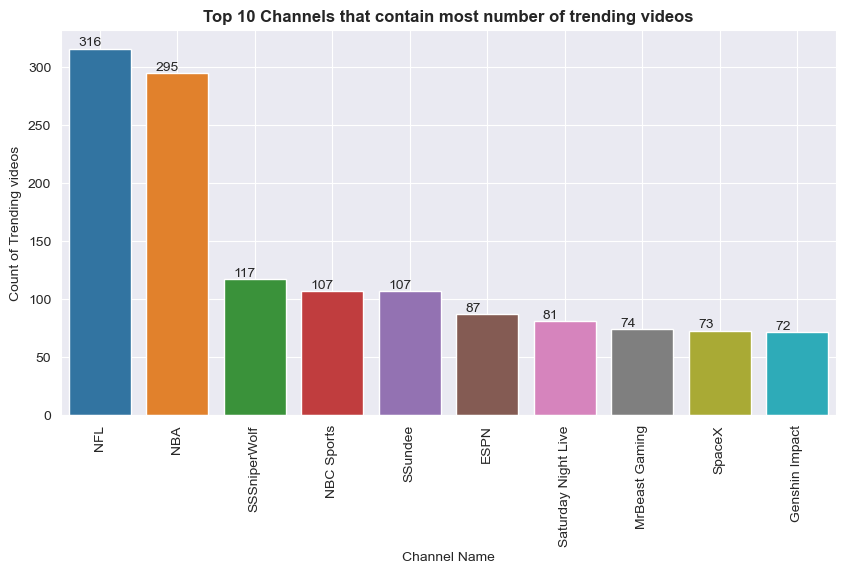

In [42]:
# Top 10 Channels that contain most number of trending videos

sns.set_style('dark')
top_10 = final_df['channelTitle'].value_counts(ascending = False)[:10]

fig, ax = plt.subplots(figsize = (10,5))
sns.barplot(top_10.index, top_10.values, ax = ax)
plt.xticks(rotation = 90)
plt.title("Top 10 Channels that contain most number of trending videos", fontweight = 'bold')


for patch in ax.patches:
    ax.annotate(int(patch.get_height()), (patch.get_x() + 0.12, patch.get_height() + 2), size = 10)

plt.xlabel('Channel Name')
plt.ylabel('Count of Trending videos')
    
plt.grid()
    
plt.show()

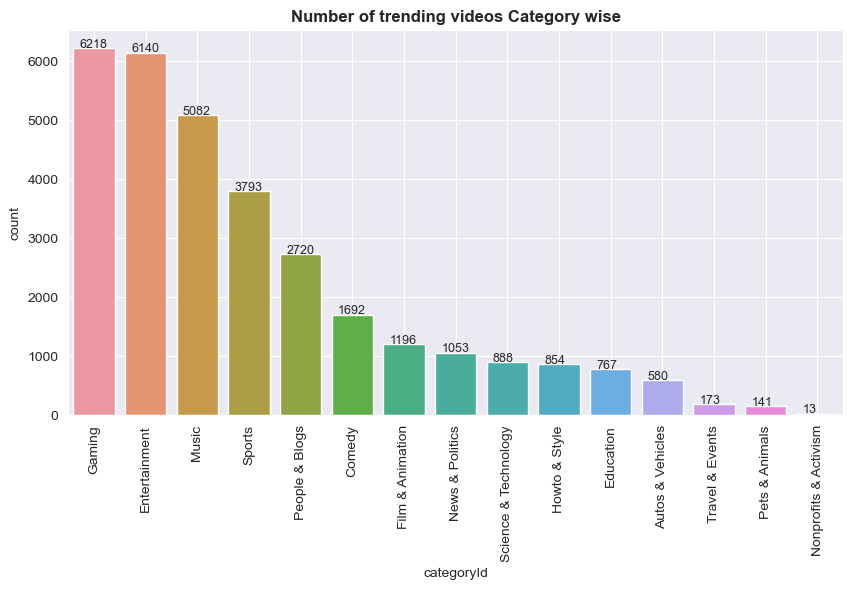

In [43]:
# Number of trending videos Category wise

fig, ax = plt.subplots(figsize = (10, 5))
sns.countplot(final_df['categoryId'], order = final_df['categoryId'].value_counts().sort_values(ascending = False).index, ax = ax)
for patch in ax.patches:
    ax.annotate(patch.get_height(), (patch.get_x() + 0.12, patch.get_height() + 20), size = 9)
plt.xticks(rotation = 90)
plt.title("Number of trending videos Category wise", fontweight = 'bold')
plt.grid()
plt.show()

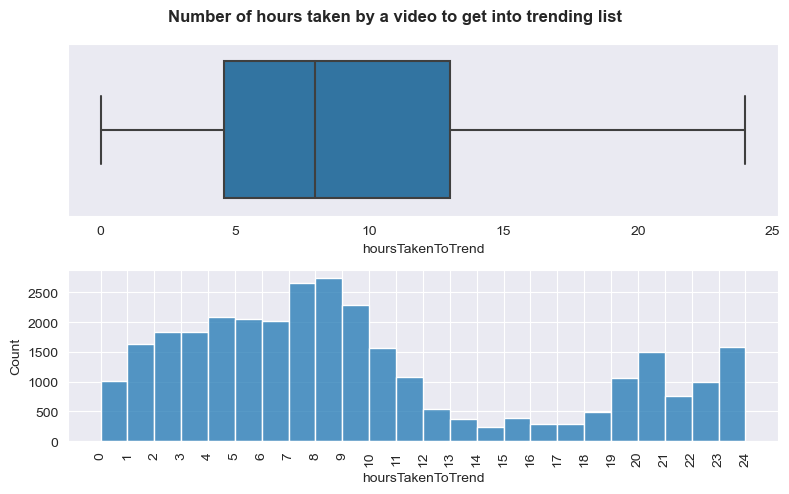

In [44]:
fig, ax = plt.subplots(2,1, figsize = (8, 5))
sns.boxplot(final_df['hoursTakenToTrend'], ax = ax[0])
sns.histplot(final_df['hoursTakenToTrend'], bins = 24, ax = ax[1])
plt.xticks(np.arange(0, 24.1, 1), rotation = 90)
plt.tight_layout()
plt.suptitle("Number of hours taken by a video to get into trending list", fontweight = 'bold')
plt.tight_layout()
plt.grid()
plt.show()

- The video gets into the trending list within a day(24 hours). This indicates that trending videos are updated every day.
- We can also observe in the histogram-plot that there is a dip in between 12 and 18 hours. Which indicates that the video is most likely to trend either in first 10 hours of publishing or the last 5 hours of the day(24 hours).


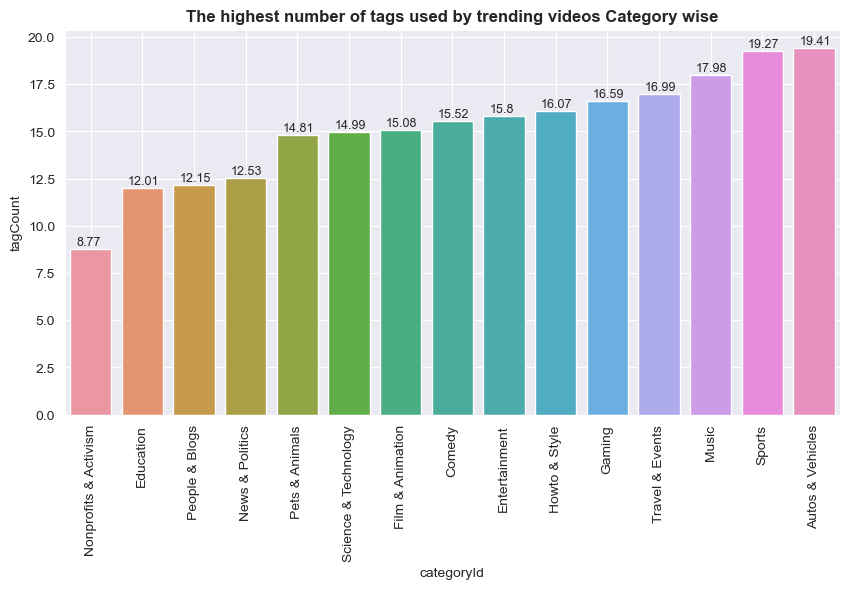

In [45]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.barplot(data = final_df, x = 'categoryId', y = 'tagCount', estimator = np.mean, ci = None,
            order = final_df.groupby('categoryId')['tagCount'].mean().sort_values().index, ax = ax)
for patch in ax.patches:
    ax.annotate(round(patch.get_height(), 2), (patch.get_x() + 0.12, patch.get_height() + 0.2), size = 9)
    
plt.title("The highest number of tags used by trending videos Category wise", fontweight = 'bold')
plt.xticks(rotation = 90)
plt.grid()
plt.show()

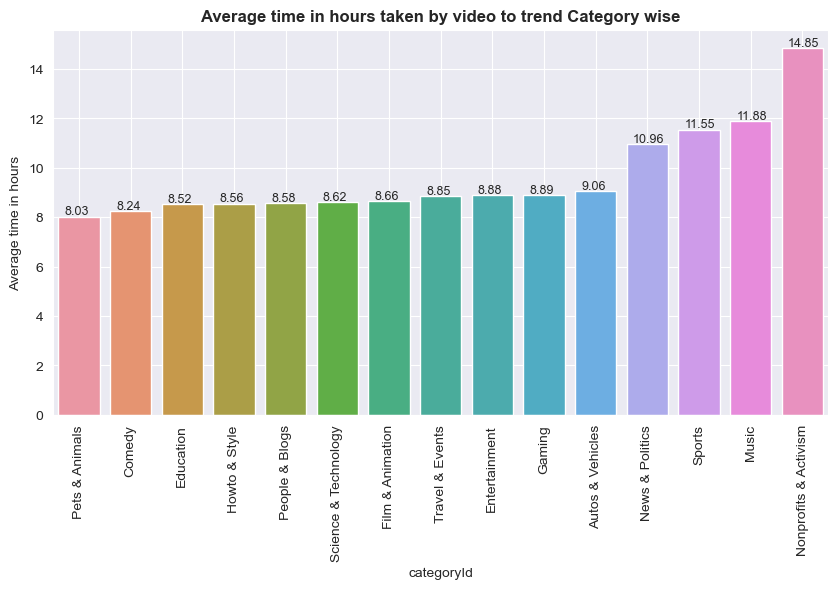

In [46]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.barplot(data = final_df, x = 'categoryId', y = 'hoursTakenToTrend', estimator = np.mean, ax = ax,
            order = final_df.groupby('categoryId')['hoursTakenToTrend'].mean().sort_values().index, ci = None)

for patch in ax.patches:
    ax.annotate(round(patch.get_height(), 2), (patch.get_x() + 0.12, patch.get_height() + 0.08), size = 9)
    
plt.title("Average time in hours taken by video to trend Category wise", fontweight = 'bold')
plt.xticks(rotation = 90)
plt.ylabel("Average time in hours")
plt.grid()
plt.show()

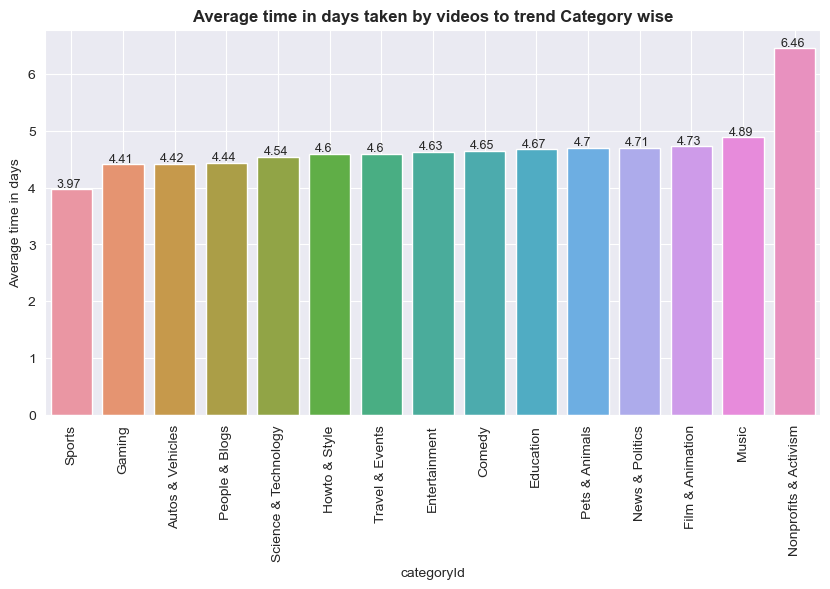

In [47]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.barplot(data = final_df, x = 'categoryId', y = 'trendingDaysDuration', estimator = np.mean,
            order = final_df.groupby('categoryId')['trendingDaysDuration'].mean().sort_values().index, ax = ax, ci = None)
plt.xticks(rotation = 90)
for patch in ax.patches:
    ax.annotate(round(patch.get_height(), 2), (patch.get_x() + 0.12, patch.get_height() + 0.04), size = 9)
    
plt.title("Average time in days taken by videos to trend Category wise", fontweight = 'bold')
plt.ylabel("Average time in days")
plt.grid()
plt.show()

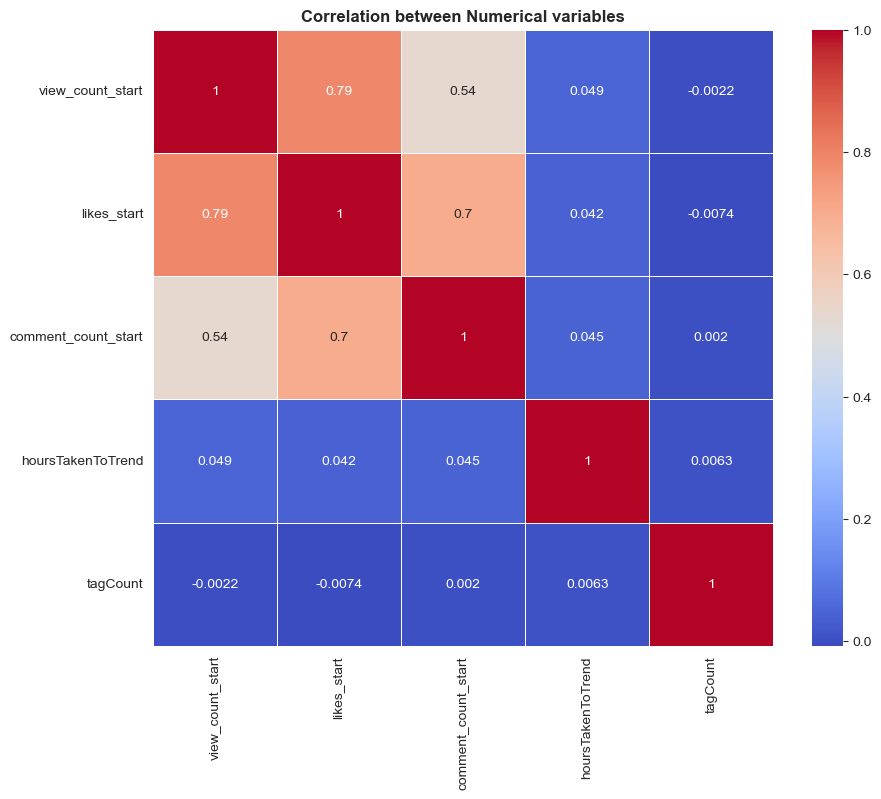

In [48]:
# Let's check the correlation between the numerical variables

plt.figure(figsize = (10, 8))
sns.heatmap(final_df[['view_count_start', 'likes_start', 'comment_count_start', 'hoursTakenToTrend', 'tagCount']].corr(), linewidths=.5, annot=True, cmap='coolwarm')
plt.title("Correlation between Numerical variables", fontweight = 'bold')
plt.show()

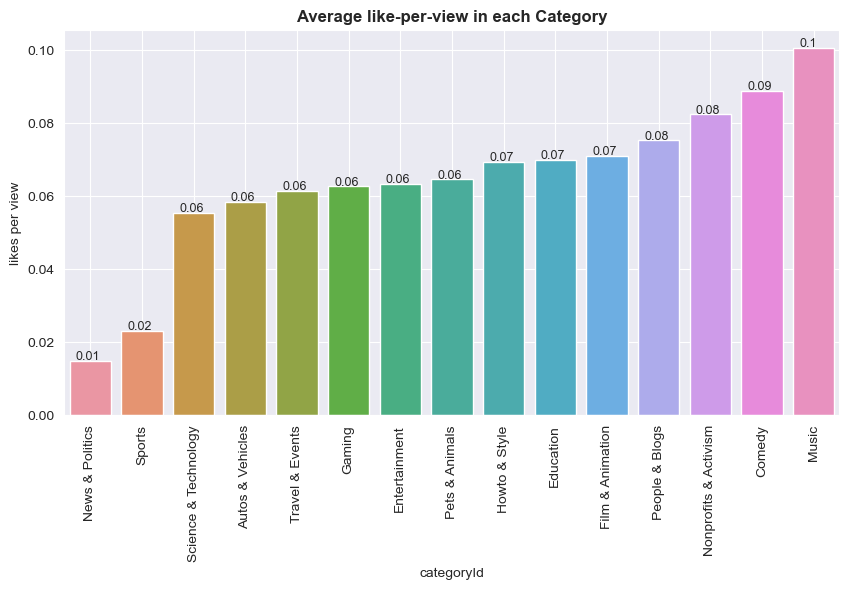

In [49]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.barplot(data = final_df, x = 'categoryId', y = 'like/view_start', 
            order = final_df.groupby('categoryId').mean()['like/view_start'].sort_values().index, ci = None)
for patch in ax.patches:
    ax.annotate(round(patch.get_height(), 2), (patch.get_x() + 0.12, patch.get_height() + 4e-4), size = 9)
    
plt.title("Average like-per-view in each Category", fontweight = 'bold')
plt.ylabel("likes per view")
plt.xticks(rotation = 90)
plt.grid()
plt.show()

# Outlier Treatment

Some of the features in our dataset had extreme outliers. To treat those outliers we have used a Log-Normalization technique.

#### Reference:
https://developers.google.com/machine-learning/data-prep/transform/normalization

### Feature 1: likes_start

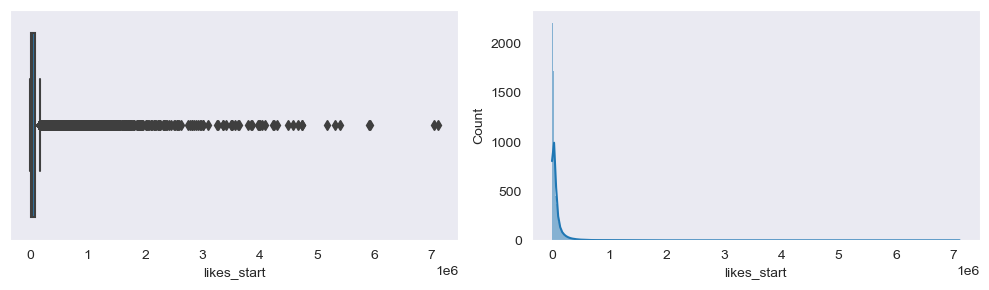

In [50]:
fig, ax = plt.subplots(1, 2, figsize = (10, 3))
sns.boxplot(final_df['likes_start'], ax = ax[0])
sns.histplot(final_df['likes_start'], ax = ax[1], kde = True)
plt.tight_layout()
plt.show()

In [51]:
# Applying log Normalization Technique

final_df['likes_start'] = np.log(final_df['likes_start'] + 1)
final_df['likes_end'] = np.log(final_df['likes_end'] + 1)

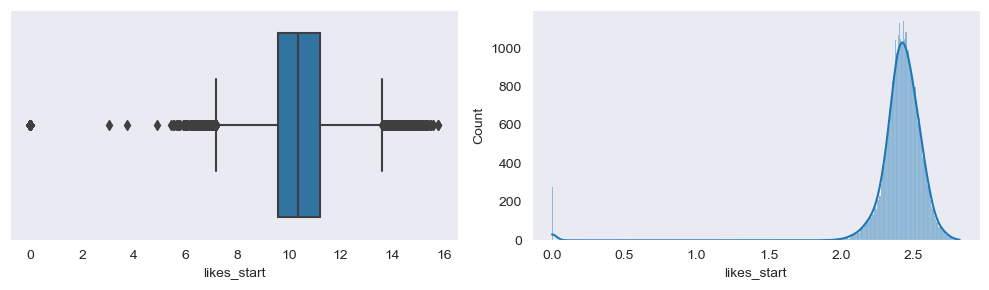

In [52]:
fig, ax = plt.subplots(1, 2, figsize = (10, 3))
sns.boxplot(final_df['likes_start'], ax = ax[0])
sns.histplot(np.log(final_df['likes_start'] + 1), ax = ax[1], kde = True)
plt.tight_layout()
plt.show()

### Feature 2: videoDuration

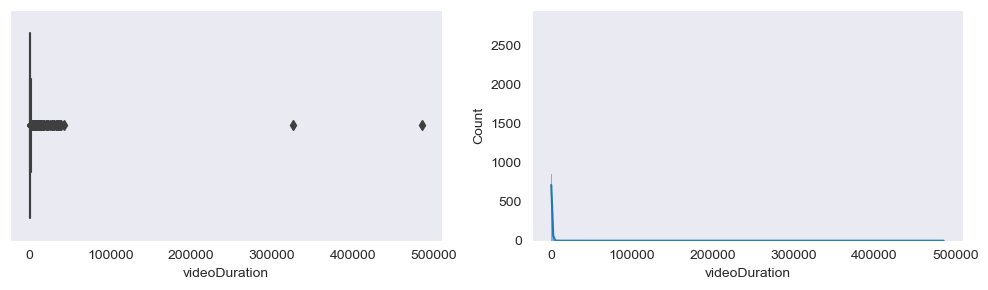

In [53]:
fig, ax = plt.subplots(1, 2, figsize = (10, 3))
sns.boxplot(final_df['videoDuration'], ax = ax[0])
sns.histplot(final_df['videoDuration'], ax = ax[1], kde = True)
plt.tight_layout()
plt.show()

In [54]:
# Applying log Normalization Technique

final_df['videoDuration'] = np.log(final_df['videoDuration'] + 1)

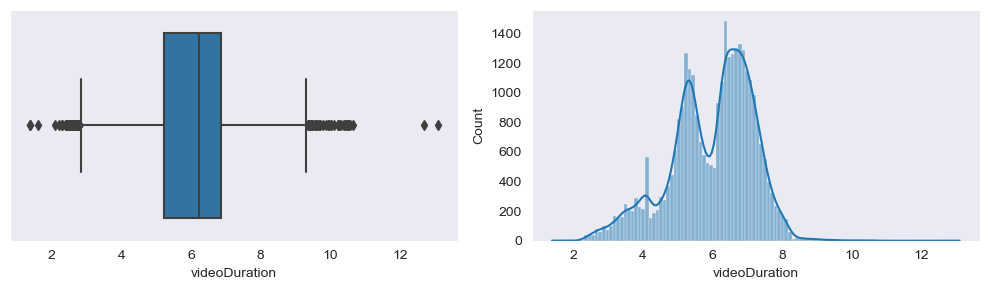

In [55]:
fig, ax = plt.subplots(1, 2, figsize = (10, 3))
sns.boxplot(final_df['videoDuration'], ax = ax[0])
sns.histplot(final_df['videoDuration'], ax = ax[1], kde = True)
plt.tight_layout()
plt.show()

### Feature 3: view_count_start

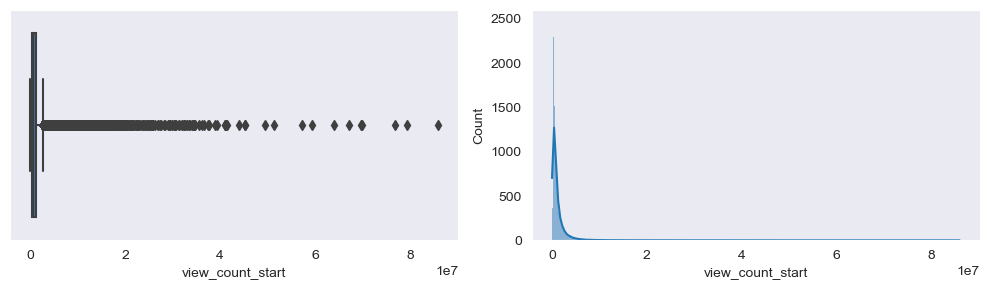

In [56]:
fig, ax = plt.subplots(1, 2, figsize = (10, 3))
sns.boxplot(final_df['view_count_start'], ax = ax[0])
sns.histplot(final_df['view_count_start'], ax = ax[1], kde = True)
plt.tight_layout()
plt.show()

In [57]:
# Applying log Normalization Technique

final_df['view_count_start'] = np.log(final_df['view_count_start'] + 1)
final_df['view_count_end'] = np.log(final_df['view_count_end'] + 1)

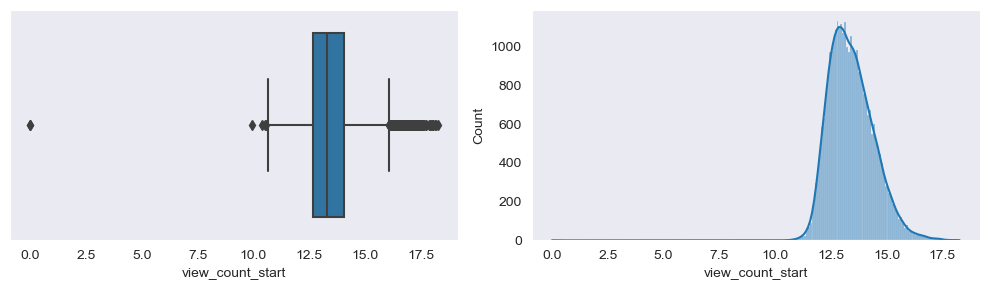

In [58]:
fig, ax = plt.subplots(1, 2, figsize = (10, 3))
sns.boxplot(final_df['view_count_start'], ax = ax[0])
sns.histplot(final_df['view_count_start'], ax = ax[1], kde = True)
plt.tight_layout()
plt.show()

### Feature 4: comment_count_start

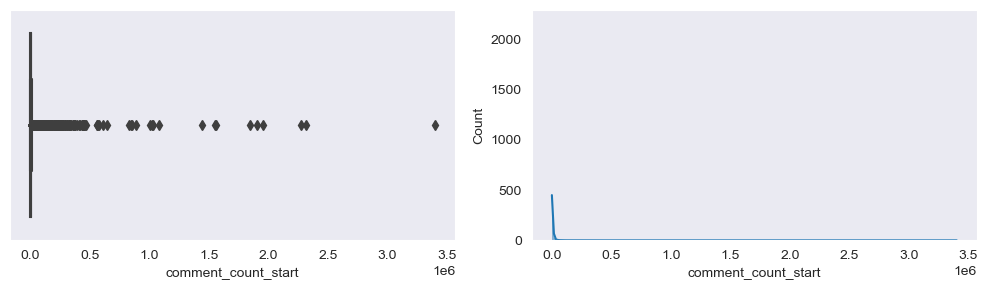

In [59]:
fig, ax = plt.subplots(1, 2, figsize = (10, 3))
sns.boxplot(final_df['comment_count_start'], ax = ax[0])
sns.histplot(final_df['comment_count_start'], ax = ax[1], kde = True)
plt.tight_layout()
plt.show()

In [60]:
# Applying log Normalization Technique

final_df['comment_count_start'] = np.log(final_df['comment_count_start'] + 1)
final_df['comment_count_end'] = np.log(final_df['comment_count_end'] + 1)

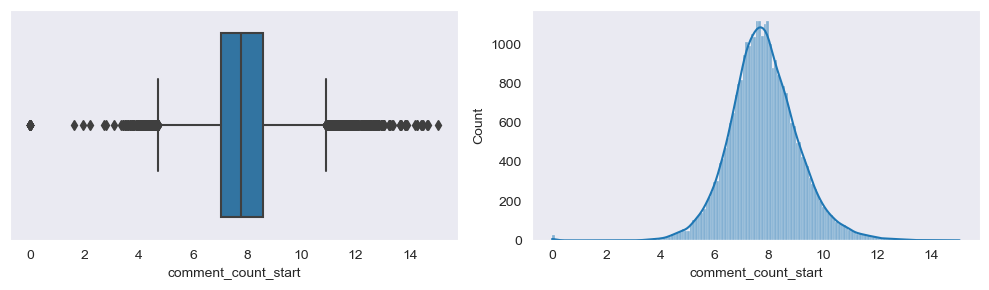

In [61]:
fig, ax = plt.subplots(1, 2, figsize = (10, 3))
sns.boxplot(final_df['comment_count_start'], ax = ax[0])
sns.histplot(final_df['comment_count_start'], ax = ax[1], kde = True)
plt.tight_layout()
plt.show()

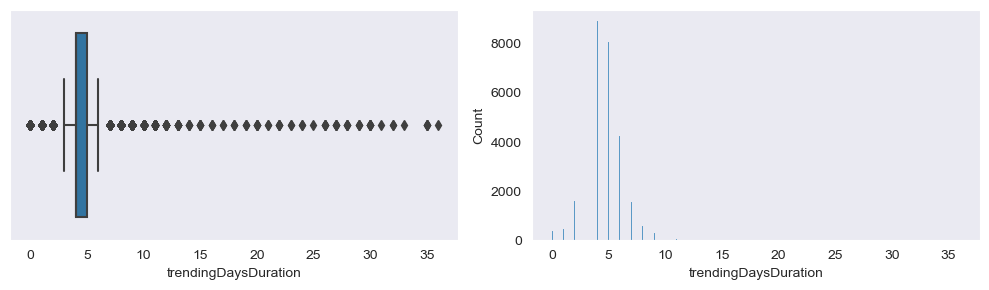

In [62]:
fig, ax = plt.subplots(1, 2, figsize = (10, 3))
sns.boxplot(final_df['trendingDaysDuration'], ax = ax[0])
sns.histplot(final_df['trendingDaysDuration'], ax = ax[1])
plt.tight_layout()
plt.show()

### Model Building

In [63]:
# Importing necessary libraries

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier 
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [64]:
# Preparing the dataframe for model building


# Dropping unnecessary columns
# Also dropping 'Comments' column. Let's build a basic model without this column
model_df = final_df.drop(columns = ['video_id', 'title', 'channelTitle', 'tags', 'description', 
                                    'Comments', 'like/view_end'])
model_df.dropna(inplace = True)


# X and Y for the model
y = model_df['view_count_end']
X = model_df.drop(columns = ['view_count_end'])

In [65]:
# Splitting the data into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 50, train_size = 0.8)

In [66]:
# Preprocessing and model building

# Selecting numerical columns
numeric_features = X_train.select_dtypes(include = ['int64', 'float64']).columns.values
# Applying Scaling for numberical columns
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)


# Selecting Categorical columns
categorical_features = X_train.select_dtypes(include = ['object']).columns.values
# Applying OneHotEncoder for categorical columns
categorical_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(drop = 'first', handle_unknown="ignore"))]
)


# Selecting Boolean datatyped columns
boolean_features = X_train.select_dtypes(include = ['bool']).columns.values
# Applying binary encoding to those columns
boolean_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(drop = 'if_binary', handle_unknown="ignore"))]
)


# Building a column transformer which applies all those above mentioned transformations
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("bool", boolean_transformer, boolean_features)
    ]
)

In [67]:
def metric_df(model, X_train, X_test, y_train, y_test):
    train_r2 = metrics.r2_score(model.predict(X_train), y_train)
    test_r2 = metrics.r2_score(model.predict(X_test), y_test)
    
    train_mse = metrics.mean_squared_error(model.predict(X_train), y_train)
    test_mse = metrics.mean_squared_error(model.predict(X_test), y_test)
    
    return pd.DataFrame([[train_r2, test_r2], [train_mse, test_mse]], 
                        columns = ['Train', 'Test'], index = ['R2_score', 'Mean Squared Error'])

## Linear Regressor

In [68]:
# Let's use Linear regression model and Pipeline the preprocessing and lr model
lr_model = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LinearRegression())]
)

In [69]:
# Training the model

lr_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  array(['likes_start', 'likes_end', 'view_count_start', 'tagCount',
       'hoursTakenToTrend', 'trendingDaysDuration', 'comment_count_start',
       'comment_count_end', 'videoDuration', 'like/view_start'],
      dtype=object)),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  array(['categoryId'], dtype=object)),
                                      

In [70]:
metric_df(lr_model, X_train, X_test, y_train, y_test)

,Train,Test
R2_score,0.939398,0.943027
Mean Squared Error,0.069004,0.063793


## Decision Tree Regressor

In [71]:
# Let's use Linear regression model and Pipeline the preprocessing and lr model
dt_model = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", DecisionTreeRegressor())]
)

In [72]:
# Training the model

dt_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  array(['likes_start', 'likes_end', 'view_count_start', 'tagCount',
       'hoursTakenToTrend', 'trendingDaysDuration', 'comment_count_start',
       'comment_count_end', 'videoDuration', 'like/view_start'],
      dtype=object)),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  array(['categoryId'], dtype=object)),
                                      

In [73]:
metric_df(dt_model, X_train, X_test, y_train, y_test)

,Train,Test
R2_score,1.0,0.924850
Mean Squared Error,0.0,0.089028


## Random Forest Regressor

In [74]:
# Let's use Linear regression model and Pipeline the preprocessing and lr model
rf_model = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestRegressor())]
)

In [75]:
# Training the model

rf_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  array(['likes_start', 'likes_end', 'view_count_start', 'tagCount',
       'hoursTakenToTrend', 'trendingDaysDuration', 'comment_count_start',
       'comment_count_end', 'videoDuration', 'like/view_start'],
      dtype=object)),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  array(['categoryId'], dtype=object)),
                                      

In [76]:
metric_df(rf_model, X_train, X_test, y_train, y_test)

,Train,Test
R2_score,0.995049,0.964158
Mean Squared Error,0.005818,0.040667


## Support Vector Machine

In [77]:
# Let's use Linear regression model and Pipeline the preprocessing and lr model
svr_model = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", SVR(kernel="rbf"))]
)

In [78]:
# Training the model

svr_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  array(['likes_start', 'likes_end', 'view_count_start', 'tagCount',
       'hoursTakenToTrend', 'trendingDaysDuration', 'comment_count_start',
       'comment_count_end', 'videoDuration', 'like/view_start'],
      dtype=object)),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  array(['categoryId'], dtype=object)),
                                      

In [79]:
metric_df(svr_model, X_train, X_test, y_train, y_test)

,Train,Test
R2_score,0.980478,0.973345
Mean Squared Error,0.022643,0.030409


### Compare model metrics

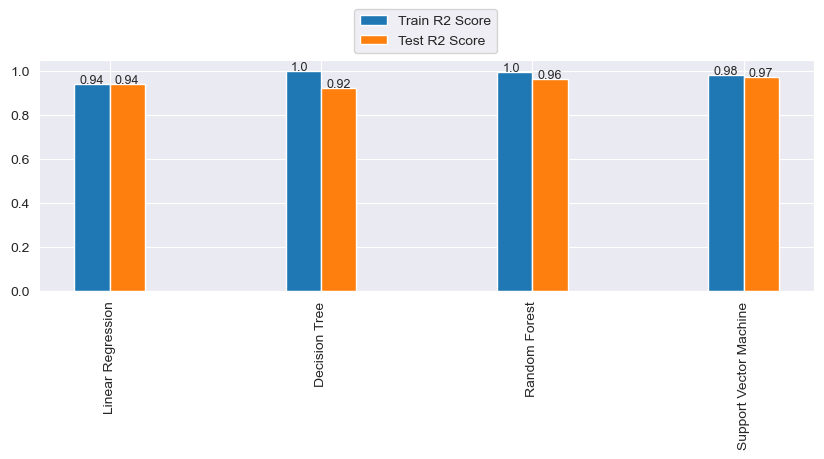

In [80]:
# Define Data

models = {'Linear Regression': lr_model, 'Decision Tree': dt_model, 'Random Forest': rf_model, 'Support Vector Machine': svr_model}

train_r2 = [metrics.r2_score(model.predict(X_train), y_train) for _, model in models.items()]
test_r2 = [metrics.r2_score(model.predict(X_test), y_test) for _, model in models.items()]

x_axis = np.arange(len(models))*1.2

# Multi bar Chart

fig, ax = plt.subplots(figsize = (10, 3))

ax.bar(x_axis + (0.20), train_r2, width=0.2, label = 'Train R2 Score')
ax.bar(x_axis + (0.20 * 2), test_r2, width=0.2, label = 'Test R2 Score')

for patch in ax.patches:
    ax.annotate(round(patch.get_height(),2), (patch.get_x() + 0.03, patch.get_height() + 0.0032), size = 9)

# Xticks

plt.xticks(x_axis + 0.3, models.keys(), rotation = 90)

# Add legend

plt.legend(bbox_to_anchor=(0.6, 1.25))

# Display

plt.grid()

plt.show()

## NLP

In [81]:
import re
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, r2_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords

In [82]:
final_df['trendingDuration'] = final_df['trendingDaysDuration'].apply(lambda x: 0 if x<=3 else(1 if x <=5 else 2))

In [83]:
final_df = final_df[final_df['description'] != '']

In [84]:
y = np.array(final_df['trendingDuration']).reshape(-1,1)
X = final_df['description']

In [85]:
X = X.apply(lambda x: x.lower())

X = X.apply(lambda x: re.sub('[^a-zA-Z\s]', '', x))

stop_words = stopwords.words('english')
X = X.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

X = X.apply(lambda x: re.sub('http.*com', '', x))

stemmer = PorterStemmer()

X =  X.apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

In [87]:
piped_model = Pipeline(steps=[("Word Vecorizer", TfidfVectorizer(max_features=50000)),
                       ("Selecting K best features", SelectKBest(score_func=chi2, k=1000)),
                           ("regressor", LogisticRegression())])

piped_model.fit(X_train, y_train)

Pipeline(steps=[('Word Vecorizer', TfidfVectorizer(max_features=50000)),
                ('Selecting K best features',
                 SelectKBest(k=1000,
                             score_func=<function chi2 at 0x000001585DFE3E50>)),
                ('regressor', LogisticRegression())])

In [88]:
accuracy_score(piped_model.predict(X_train), y_train)

0.5878505437004333

In [89]:
accuracy_score(piped_model.predict(X_test), y_test)

0.553629823413996

In [90]:
from sklearn.feature_extraction.text import CountVectorizer

In [91]:
vectorizer = CountVectorizer(max_features=10000)

X_train_vec = vectorizer.fit_transform(X_train)

X_test_vec = vectorizer.transform(X_test)

In [92]:
X_train_vec = X_train_vec.toarray()

In [93]:
X_test_vec = X_test_vec.toarray()

In [94]:
ohe = OneHotEncoder()

y_train = ohe.fit_transform(y_train)

y_test = ohe.transform(y_test)

In [95]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(X_train_vec.shape[1],)))
model.add(layers.Dense(12, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

In [96]:
model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])

In [97]:
y_train = y_train.toarray()

y_test = y_test.toarray()

In [98]:
history = model.fit(X_train_vec, y_train, epochs=5, batch_size=512, validation_data=(X_test_vec, y_test))

Epoch 1/5
48/48 [==============================] - 2s 27ms/step - loss: 1.0115 - accuracy: 0.5477 - val_loss: 0.9856 - val_accuracy: 0.5468
Epoch 2/5
48/48 [==============================] - 1s 22ms/step - loss: 0.9142 - accuracy: 0.5719 - val_loss: 0.9828 - val_accuracy: 0.5405
Epoch 3/5
48/48 [==============================] - 1s 20ms/step - loss: 0.8339 - accuracy: 0.6244 - val_loss: 1.0118 - val_accuracy: 0.5376
Epoch 4/5
48/48 [==============================] - 1s 19ms/step - loss: 0.7561 - accuracy: 0.6765 - val_loss: 1.0520 - val_accuracy: 0.5229
Epoch 5/5
48/48 [==============================] - 1s 18ms/step - loss: 0.6857 - accuracy: 0.7143 - val_loss: 1.1146 - val_accuracy: 0.5173
